In [12]:
# Main goal of this excercise is to explore bikes that were stolen or taken for way longer than necessary 

import pandas as pd
import pandas_gbq as gpd
import numpy as np
import tqdm
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import queries as q

project_id = 'cab-law'
client = bigquery.Client(project=project_id)

In [13]:
query = """
    SELECT * FROM `bigquery-public-data.new_york.citibike_trips`
    limit 10;
"""
sample = gpd.read_gbq(query, project_id=project_id, progress_bar_type='tqdm')
sample.head()



Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1273,2016-09-28 17:19:42+00:00,2016-09-28 17:40:56+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,263,Elizabeth St & Hester St,40.717591,-73.996224,26688,Subscriber,1991,male
1,1646,2016-07-12 17:27:00+00:00,2016-07-12 17:54:27+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,263,Elizabeth St & Hester St,40.717591,-73.996224,24883,Subscriber,1991,male
2,434,2015-12-08 15:56:28+00:00,2015-12-08 16:03:42+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3234,E 40 St & Madison Ave,40.751594,-73.980432,17519,Subscriber,1965,female
3,897,2015-10-22 10:21:33+00:00,2015-10-22 10:36:31+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3234,E 40 St & Madison Ave,40.751594,-73.980432,19019,Subscriber,1978,male
4,270,2015-12-18 14:45:31+00:00,2015-12-18 14:50:02+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3234,E 40 St & Madison Ave,40.751594,-73.980432,23049,Subscriber,1987,male


In [14]:
info_query = """
    SELECT count(distinct(bikeid)) as num_bikes, count(*) as num_trips, count(distinct(start_station_id)) as num_stations FROM `bigquery-public-data.new_york.citibike_trips`
"""
info = gpd.read_gbq(info_query, project_id=project_id, progress_bar_type='tqdm')
print(info)



Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
   num_bikes  num_trips  num_stations
0      11852   33319019           655


In [16]:
%%capture
full_query = """
select * from `bigquery-public-data.new_york.citibike_trips`
"""
full_results = gpd.read_gbq(full_query, project_id=project_id, use_bqstorage_api=True)

In [17]:
bike_counts = pd.DataFrame(columns=['timestamp', 'station_id', 'bike_change'])

# Create a DataFrame for start stations
start_stations = full_results[['starttime', 'start_station_id']].copy()
start_stations['bike_change'] = -1

# Create a DataFrame for end stations
end_stations = full_results[['stoptime', 'end_station_id']].copy()
end_stations['bike_change'] = 1

# Rename columns for concatenation
start_stations.columns = ['timestamp', 'station_id', 'bike_change']
end_stations.columns = ['timestamp', 'station_id', 'bike_change']

# Concatenate the start and end stations DataFrames
bike_counts = pd.concat([start_stations, end_stations], ignore_index=True)

In [18]:
# Floor the timestamp to the minute
bike_counts['timestamp'] = bike_counts['timestamp'].dt.floor('min')

# Group by timestamp and station_id and sum the bike changes
bike_counts = bike_counts.groupby(['timestamp', 'station_id']).sum().reset_index()

In [39]:
# Let's grab a few of these stations
bike_counts.groupby('station_id')


,timestamp,station_id,bike_change
0,2013-07-01 00:00:00+00:00,164,-1
1,2013-07-01 00:00:00+00:00,388,-1
2,2013-07-01 00:01:00+00:00,293,-2
3,2013-07-01 00:01:00+00:00,382,-1
4,2013-07-01 00:01:00+00:00,511,-1


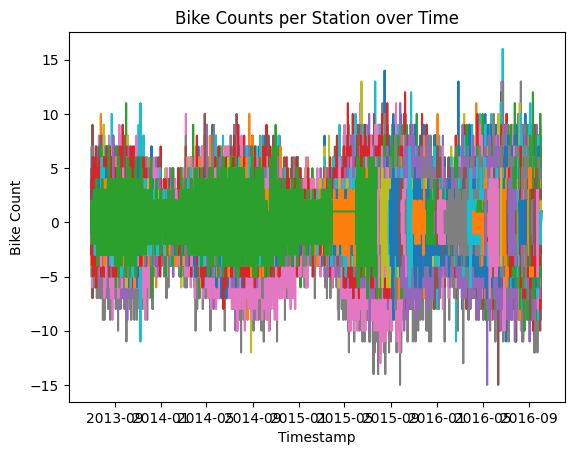

In [22]:
grouped = bike_counts.groupby('station_id')

# Plot bike counts for each station_id
for station_id, group in grouped:
    plt.plot(group['timestamp'], group['bike_change'], label=f'Station {station_id}')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Bike Count')
plt.title('Bike Counts per Station over Time')

# Show plot
plt.show()

In [25]:
# That's too messy. Let's get the 5 stations with the highest standard deviation
std_devs = bike_counts.groupby('station_id')['bike_change'].std().reset_index(name='standard_dev').sort_values(by='standard_dev', ascending=False)
top_five = std_devs.head(5)
top_five


,station_id,standard_dev
504,3230,2.007743
333,3014,2.001268
539,3282,1.654421
478,3182,1.640842
528,3257,1.625404


In [34]:
top_stations = bike_counts.loc[bike_counts['station_id'].isin(top_five['station_id'])]


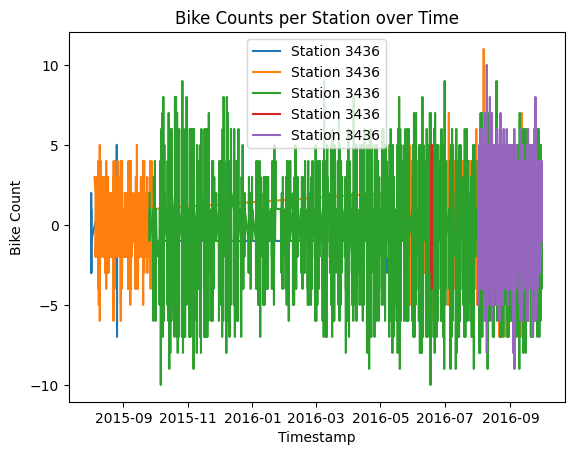

In [36]:
for idx,group in top_stations.groupby('station_id'):
    plt.plot(group['timestamp'], group['bike_change'], label=f'Station {station_id}')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Bike Count')
plt.title('Bike Counts per Station over Time')

# Add legend
plt.legend()

# Show plot
plt.show()